# MNIST Simple Pointer Network

In this notebook we will learn how to create a simple [Pointer Network](https://arxiv.org/abs/1506.03134) (Vinyals et al. 2015) for solving a dummy task on the MNIST dataset.

A Pointer Network uses the **attention mechanism’s** output to model the conditional probability of each element on its input. This can be extremely useful in tasks that require selecting one (or more) elements of the input sequence/set to be solved.

In this notebook we will play with a simple Pointer net to solve the following task: Given an MNIST image with a (query) digit we want our model to find the image that contains the consecutive digit to the query image among a set of input images. For example, imagine we use an image with the digit "5" as query and let the input of the model be a set of 10 images with different digits, the output of our model must be a probability distribution over those 10 images indicating the presence or not of the digit "6" in each of them.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  2.6.0+cu124


In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Create the dataset

Let's start creating a Dataset class to understand better the task we want to solve. Each sample in our dataset will be formed by:

* a query image
* a set of 10 images, 9 of them selected randomly (distractors) and one selected as the consecutive digit of the digit in the query image.
* the ground truth: a 10-D one hot vector indicating the position of the image we want our model to select ("point to").

In [3]:
class MNISTAttentionDataset(Dataset):
    """MNIST attention toy dataset."""

    def __init__(self, num_inputs, train=True):
        """
        Args:
            num_inputs (int) - The number of images in the input of our model.
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
        """

        self.num_inputs = num_inputs
        self.mnist = torchvision.datasets.MNIST('../data', train=train, download=True)

        # dict with samples for each class label
        self.data = {}
        for label in range(10):
            #Collect in separate lists the different digits, and normalise values to [0, 1]
            self.data[label] = self.mnist.data[self.mnist.targets == label] / 255.0



    def __len__(self):
        # The length makes little sense here, as we generate samples dynamically
        # Here we return the number of images originally in the dataset
        return self.mnist.data.shape[0]

    def __getitem__(self, idx):
        """
        Args:
            idx (int) - an index indicating which digit should be used as query
        """
        c = self.mnist.targets[idx].item()     # Find out which is the class of the digit requested
        query = self.mnist.data[idx].flatten() / 255.0 # Get the data for the digit requested

        correct_pos = np.random.randint(0, self.num_inputs) # Decide on a random position where the correct answer will be

        inputs = np.zeros((self.num_inputs, 784)) # Create an array to hold the inputs (from which we have to select one)
        for j in range(self.num_inputs):
            if j == correct_pos: # In the correct position, place a random digit that comes from the c+1 class
                idx = np.random.randint(0,self.data[(c+1)%10].shape[0])
                inputs[j,:] = self.data[(c+1)%10][idx,:].flatten()
            else: # In the rest of the positions, place random digits that come from the rest of the classes
                c_distractor = np.random.choice([n for n in [0,1,2,3,4,5,6,7,8,9] if n!=(c+1)%10])
                idx = np.random.randint(0,self.data[c_distractor].shape[0])
                inputs[j,:] = self.data[c_distractor][idx,:].flatten()

        sample = {'x': inputs, 'query': query, 'y': correct_pos}

        return sample

In [4]:
num_inputs = 10

train_dataset = MNISTAttentionDataset(num_inputs, train=True)
test_dataset = MNISTAttentionDataset(num_inputs, train=False)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = 1000, shuffle = False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


### Visualize one training sample

<ipython-input-3-949448a67f37>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[c_distractor][idx,:].flatten()
<ipython-input-3-949448a67f37>:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[(c+1)%10][idx,:].flatten()


Data: (10, 784), Query: torch.Size([784])


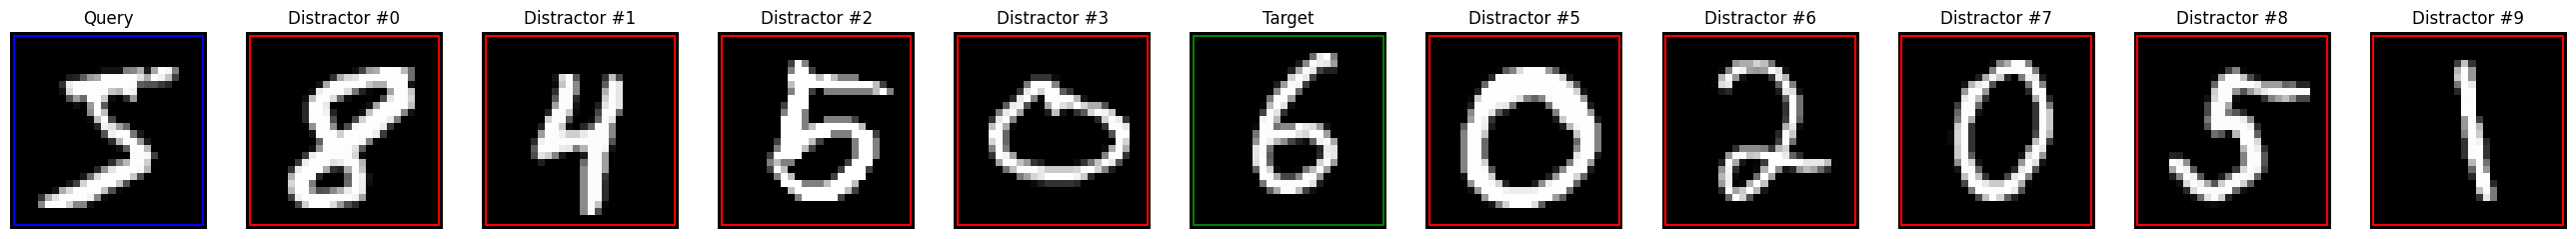

In [5]:
sample = train_dataset[0]

print(f"Data: {sample['x'].shape}, Query: {sample['query'].shape}")

fig = plt.figure(figsize=(33, 3))
plt.tight_layout()

ax = plt.subplot(1, num_inputs + 1, 1)
image = sample['query'].reshape(28,28)
plt.imshow(image, cmap='gray')
plt.plot([0,27,27,0,0], [0,0,27,27,0], c='b') # Draw a blue box around the query sample
ax.set_title('Query')
ax.axis('off')

for i in range(num_inputs):
    ax = plt.subplot(1, num_inputs + 1, i+2)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    image = sample['x'][i].reshape(28,28)
    plt.imshow(image, cmap='gray')
    if i == sample['y']:
        plt.plot([0,27,27,0,0], [0,0,27,27,0], c='g') # Draw a green box around the correct sample
        ax.set_title('Target')
    else:
        plt.plot([0,27,27,0,0], [0,0,27,27,0], c='r') # Draw a red box around the wrong sample
        ax.set_title('Distractor #{}'.format(i))
    ax.axis('off')

plt.show()

### Create the model

In [6]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, num_inputs, hidden_dim):
        super(AttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_inputs = num_inputs
        self.input_dim  = input_dim

        # Weights (Fully Connected layers)
        self.fc_q = nn.Linear(input_dim, hidden_dim) # Query FC
        self.fc_k = nn.Linear(input_dim, hidden_dim) # Keys FC. Here the input acts as the keys, and there is no value
        self.fc_v = nn.Linear(hidden_dim, 1) # Values FC

    def scoringAdditive(self, query, keys):
        # Query is                                              (B X 1 X input_dim)
        # Repeat (tile) the query so that it has the same size as the keys (input)
        query = query.repeat(1, self.num_inputs, 1)           # (B X num_inputs X input_dim)
        query = torch.tanh(self.fc_q(query))                  # (B X num_inputs X hidden_dim)

        # Keys is                                               (B X num_inputs X input_dim)
        keys = torch.tanh(self.fc_k(keys))                    # (B X num_inputs X hidden_dim)

        # Attention Score
        score = torch.tanh(query + keys )                     # (B X num_inputs X hidden_dim)
        score = self.fc_v(score)                              # (B X num_inputs X 1)
        return score

    def forward(self, x, query):
        query = query.unsqueeze(1) # (B x input_dim) -> (B x 1 x input_dim)

        # Calculate attention scores
        output = self.scoringAdditive(query, x)
        output = output.squeeze()       # (B x 1 x num_inputs) -> (B x num_inputs)
        return output

<font color="blue">

**QUESTION**: The Additive score gives logits that we should pass through a softmax to get the final attention weights. Why is there no softmax in the model above?</font>

<font color="green">
    
**ANSWER**: The loss function we use to train this is the `nn.CrossEntropyLoss()`. Although it is called "CrossEntropy" in reality it expects logits, and does the softmax and the cross entropy jointly. This is why we do not do softmax explicitly before.</font>

In [7]:
input_dim, num_inputs, hidden_dim = (784, 10, 256)

model = AttentionModel(input_dim, num_inputs, hidden_dim)
print(model)

AttentionModel(
  (fc_q): Linear(in_features=784, out_features=256, bias=True)
  (fc_k): Linear(in_features=784, out_features=256, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
)


### Define the training method and train

In [8]:
def train(model, device, train_loader, criterion, optimizer, epoch, log_interval = 100):
    # Method to perform one epoch of training
    model.train()
    loss_values = []

    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['x'].float()
        query = sample_batched['query'].float()
        target = sample_batched['y']
        #print(data.shape, query.shape)
        data, query, target = data.to(device), query.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data, query)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_values.append(loss.detach().cpu().item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return loss_values

In [9]:
model = model.to(device)

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

epochs = 10

loss_history = []
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, criterion, optimizer, epoch)
    loss_history += loss_values

<ipython-input-3-949448a67f37>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[c_distractor][idx,:].flatten()
<ipython-input-3-949448a67f37>:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[(c+1)%10][idx,:].flatten()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323496
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.746668
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.160723
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.703118
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.700564
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.659640
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.672008
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.613552
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.470871
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.406851
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.490616
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.518722
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.555605
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.470546
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.304088
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.515653
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.421828
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.325103
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.281202
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.205235
Train Epoch:

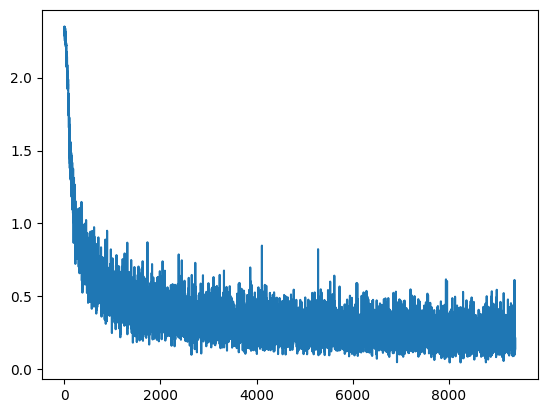

In [10]:
plt.plot(loss_history)

### Evaluate the trained model

In [11]:
def evaluate(model, device, test_loader):
    model.eval()
    total = 0.
    ok = 0.
    for batch_idx, sample_batched in enumerate(test_loader):
        data = sample_batched['x'].float()
        query = sample_batched['query'].float()
        target = sample_batched['y'].numpy()
        data, query = data.to(device), query.to(device)

        output = model(data, query)
        pred = np.argmax(output.detach().cpu().numpy(), axis=1)

        ok += np.sum(pred == target)
        total += len(test_loader)

    print('Accuracy = ', ok/total)

In [12]:
evaluate(model, device, test_loader)

<ipython-input-3-949448a67f37>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[c_distractor][idx,:].flatten()
<ipython-input-3-949448a67f37>:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[(c+1)%10][idx,:].flatten()


Accuracy =  92.01


<font color="blue">

**EXERCISE 1**: Starting from the previous model as a template, implement the Dot-product Attention scoring function and substitute the additive one we were using before. Retrain and evalute the model.</font>

<font color="blue">

> Hint: To transpose a tensor along specific dimensions you can use `torch.permute()`
</font>


<font color="blue">

> Hint: To perform a batch matrix-matrix product, use the function `torch.bmm()` https://pytorch.org/docs/stable/generated/torch.bmm.html
</font>

In [13]:
# YOUR CODE HERE


In [14]:
# SOLUTION

class AttentionModel_Dot(nn.Module):
    def __init__(self, input_dim, num_inputs, hidden_dim):
        super(AttentionModel_Dot, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_inputs = num_inputs
        self.input_dim  = input_dim

        # Weights (Fully Connected layers)
        self.fc_q = nn.Linear(input_dim, hidden_dim) # Query FC
        self.fc_k = nn.Linear(input_dim, hidden_dim) # Keys FC. Here the input acts as the keys, and there is no value
        self.fc_v = nn.Linear(hidden_dim, 1) # Values FC

    def scoringAdditive(self, query, keys):
        # Query is                                              (B X 1 X input_dim)
        # Repeat (tile) the query so that it has the same size as the keys (input)
        query = query.repeat(1, self.num_inputs, 1)           # (B X num_inputs X input_dim)
        query = torch.tanh(self.fc_q(query))                  # (B X num_inputs X hidden_dim)

        #Keys is                                                (B X num_inputs X input_dim)
        keys = torch.tanh(self.fc_k(keys))                    # (B X num_inputs X hidden_dim)

        # Attention Score
        score = torch.tanh(query + keys )                     # (B X num_inputs X hidden_dim)
        score = self.fc_v(score)                              # (B X num_inputs X 1)
        return score

    def scoringDot(self, query, keys):
        # Query is                                              (B X 1 X input_dim)
        query = torch.tanh(self.fc_q(query))                  # (B X 1 X hidden_dim)

        # Keys is                                               (B X num_inputs X input_dim)
        keys = torch.tanh(self.fc_k(keys))                    # (B X num_inputs X hidden_dim)

        # Attention Score
        keys = keys.permute(0,2,1)                            # (B X hidden_dim X num_inputs)
        score = torch.bmm(query, keys)                        # (B X 1 X num_inputs)
        score /= np.sqrt(num_inputs)
        score = score.permute(0,2,1)                          # (B X num_inputs x 1)
        return score

    def forward(self, x, query):
        query = query.unsqueeze(1) # (B x input_dim) -> (B x 1 x input_dim)

        # Calculate attention scores
        output = self.scoringDot(query, x)
        output = output.squeeze()       # (B x 1 x num_inputs) -> (B x num_inputs)
        return output

In [15]:
# SOLUTION (cont)

input_dim, num_inputs, hidden_dim = (784, 10, 256)

modelDot = AttentionModel_Dot(input_dim, num_inputs, hidden_dim)
print(modelDot)

AttentionModel_Dot(
  (fc_q): Linear(in_features=784, out_features=256, bias=True)
  (fc_k): Linear(in_features=784, out_features=256, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
)


In [16]:
# SOLUTION (cont)

modelDot = modelDot.to(device)

optimizer = optim.Adam(modelDot.parameters())

criterion = nn.CrossEntropyLoss()

epochs = 10

loss_history = []
for epoch in range(1, epochs + 1):
    loss_values = train(modelDot, device, train_loader, criterion, optimizer, epoch)
    loss_history += loss_values

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311312


<ipython-input-3-949448a67f37>:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[(c+1)%10][idx,:].flatten()
<ipython-input-3-949448a67f37>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[c_distractor][idx,:].flatten()


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.888986
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.085192
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.498677
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.705745
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.607845
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.497531
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.626899
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.630962
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.347450
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.554107
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.573408
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.437436
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.489943
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.316513
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.424439
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.176274
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.365373
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.199968
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.688116
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.420478
Train Epoch:

In [17]:
# SOLUTION (cont)

evaluate(modelDot, device, test_loader)

<ipython-input-3-949448a67f37>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[c_distractor][idx,:].flatten()
<ipython-input-3-949448a67f37>:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  inputs[j,:] = self.data[(c+1)%10][idx,:].flatten()


Accuracy =  94.9


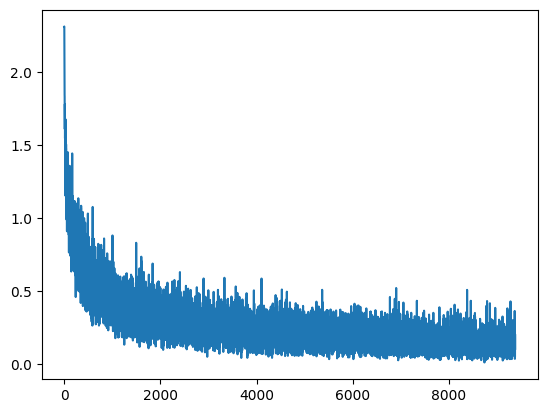

In [18]:
# SOLUTION (cont)

plt.plot(loss_history)